In [1]:
import numpy as np
import pandas as pd
import pyreadr
import datetime
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS

In [2]:
# define paths
data_path = '/Users/simonneumeyer/Dropbox/Ethiopia IE - Road Safety/Data/'
crashes_path = 'ETRE - Crashes/'
crash_file = 'FinalData/crashes.csv'
traffic_path = 'ETRE - Traffic/'
traffic_file = 'FinalData/traffic.pq'
precipitation_path = 'Precipitation/'
precipitation_file = 'FinalData/precipitation.csv'

In [3]:
# load data
traffic_final = pd.read_parquet(data_path + traffic_path + traffic_file, engine='pyarrow')
precipitation_final = pd.read_csv(data_path + precipitation_path + precipitation_file)
crashes_final = pd.read_csv(data_path + crashes_path + crash_file)

traffic = pd.read_parquet(data_path + 'Time Segment Data/traffic_feature.pq', engine='pyarrow')
hourly = pd.read_stata(data_path + 'Daily and Hourly Data/FinalData/hourly.dta')

# segment-time panel

In [4]:
# create rectangularized segment-time dataset:
date_range = pd.date_range(precipitation_final.date.min(), precipitation_final.date.max())
date_range = list(date_range)
hour_range = list(range(0,24))
km_range = [1000*x for x in range(0,79)]
segment_time = pd.DataFrame([[x,y,z] for x in date_range for y in hour_range for z in km_range])
segment_time = segment_time.rename(columns={0:'date', 1:'hour', 2:'km_from_addis'})

# crashes & precipitation:

In [5]:
# rename date & hour:
crashes_final = crashes_final.rename(columns={'accident_date': 'date', 'time_of_accident_hour': 'hour'})

# create accident counts and add them to segment-time dataset:
crashes_final['accidents'] = 1
crashes_final['km_from_addis'] = crashes_final.distance_from_addis.round(-3)
accid_count = crashes_final.groupby(['date', 'hour', 'km_from_addis'])['accidents'].count()
accid_count = accid_count.reset_index()
accid_count.date = pd.to_datetime(accid_count.date)
segment_time = segment_time.merge(accid_count, how='left', on=['date', 'hour', 'km_from_addis'])

In [6]:
# add precipitation:
precipitation_final.date = pd.to_datetime(precipitation_final.date)
segment_time = segment_time.merge(precipitation_final[['date', 'precip_mm']], on='date', how='left')

In [7]:
# fill missing data with 0 only for the date range where we have crashes data (2015-2017)
crashes_start_date = pd.to_datetime('2015-01-01')
crashes_end_date = pd.to_datetime(crashes_final.date).max()
condition = (segment_time['date'] >= crashes_start_date) & (segment_time['date'] <= crashes_end_date)
segment_time.loc[condition, 'accidents'] = segment_time.loc[condition, 'accidents'].fillna(0)

In [8]:
# merging accident data into it:
relevant_crash_vars = ['distance_from_addis', 'case_no', 'date', 'day', 'hashed_plate_number',
       'vehicle_type', 'vehicle_brand', 'direction',
       'road_geometry', 'road', 'weather', 'fatality', 'serious_injury',
       'slight_injury', 'cause_of_accident', 'type_of_accident',
       'year_of_production', 'owner', 'driver_age', 'gender', 'address',
       'drivers_license_level', 'license_year', 'license_region', 'experience',
       'relation_with_vehicle', 'etre_asset_damage', 'ownership',
       'extent_of_damage', 'year', 'hour',
       'time_of_accident_minute', 'accident_datetime',
       'accident_location_original', 'accident_location_text', 'latitude',
       'longitude', 'axle_number', 'cause_of_accident_simple',
       'type_of_accident_simple', 'accident_cause_vehicle_human',
       'km_from_addis']
crashes_final.date = pd.to_datetime(crashes_final.date)
segment_time = segment_time.merge(crashes_final[relevant_crash_vars], how='left', on=['date', 'hour', 'km_from_addis'])


In [9]:
# option to load intermediate file:
#segment_time = pd.read_parquet(data_path + 'Time Segment Data/segment_time_panel_intermediate.pq', engine='pyarrow')


# preprocess

In [10]:
# kick out NAs: (where we don't have accident data)
segment_time = segment_time.dropna(subset=['accidents'])
segment_time = segment_time.reset_index()

# create km_from_addis variable:
traffic['km_from_addis'] = traffic.km.apply(lambda x: 1000 * (80.0-x)) #80: assuming km in traffic data are from adama, not addis.
traffic = traffic.rename({'tstamp': 'date', 'count': 'traffic'}, axis=1)

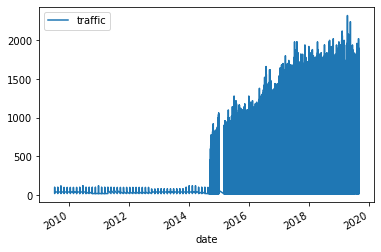

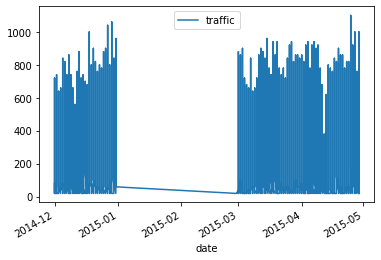

In [11]:
# show why we drop some data:

#segment_time.fillna(0).plot(x='date', y='count')
traffic.plot(x='date', y='traffic')
plt.show()
#traffic
cond_1 = (traffic.date > pd.to_datetime('2014-11-30'))
cond_2 = (traffic.date < pd.to_datetime('2015-04-30'))

traffic[cond_1 & cond_2].plot(x='date', y='traffic')
plt.show()
# It seems that there is a 2-month gap of traffic data for January & February 2015. 
# We shall consider only traffic data after February 2015 (Before 2015 there is no accidents data anyway)

In [12]:
# drop accident data older than March 2015:
condition = (segment_time.date >= pd.to_datetime('2015-03-01'))
segment_time = segment_time[condition]

# traffic and hourly (and segment) data:

In [13]:
# merge traffic with accidents:
segment_time = segment_time.merge(traffic, how='left', on=['date', 'hour', 'km_from_addis'])

In [14]:
# Now that we removed missing data we can safely assume that remaining traffic NAs are incidents of 
# no traffic in that particular time-km segment:
segment_time['traffic'] = segment_time['traffic'].fillna(0)

In [15]:
# add hourly data:

hourly['hour'] = hourly.date_hour.apply(lambda x: x.hour)
hourly = hourly.drop('precip_mm', axis=1)

# aggregate both directions (subject to change):
hourly = hourly.groupby('date_hour').agg(
    {
    'speed_mean': 'mean', 'speed_p10': 'mean', 'crash': 'sum', 'speed_p25': 'mean',
        'speed_p50': 'mean', 'speed_p75': 'mean', 'speed_p90': 'mean', 
        'N_crashes': 'sum', 'N_vehicles': 'sum', 'holiday': 'mean', 
        'holiday_plusminus_1day': 'mean', 'holiday_plusminus_2day': 'mean',
        'hour': 'mean', 'date': 'min'
    }
).reset_index()

# merge with time-segment panel:
segment_time = segment_time.merge(hourly, how='left', on=['date', 'hour'], validate='many_to_one')

In [16]:
# add segment data:
segment_data = pyreadr.read_r(data_path + 'Addis Adama Expressway/Data/segments_data/merged_data/aae_segment_data.Rds')
segment_data = segment_data[None]
segment_data

,longitude,latitude,distance_from_addis,N_crashes,N_crashes_to_addis,N_crashes_to_adama,N_crashes_2015,N_crashes_2017,N_crashes_2016,N_crashes_to_addis_2015,N_crashes_to_adama_2017,N_crashes_to_addis_2017,N_crashes_to_addis_2016,N_crashes_to_adama_2016,N_crashes_to_adama_2015,dist_plaza_k2_km,dist_plaza_k16_km,dist_plaza_k33_km,dist_plaza_k52_km,dist_plaza_k60_km,dist_plaza_k64_km,dist_plaza_nearest_km,turnangle_10m,turnangle_50m,turnangle_100m,turnangle_250m,turnangle_500m,N_crashes_MA_sum_500m,N_crashes_to_addis_MA_sum_500m,N_crashes_to_adama_MA_sum_500m,N_crashes_2015_MA_sum_500m,N_crashes_2017_MA_sum_500m,N_crashes_2016_MA_sum_500m,N_crashes_to_addis_2015_MA_sum_500m,N_crashes_to_adama_2017_MA_sum_500m,N_crashes_to_addis_2017_MA_sum_500m,N_crashes_to_addis_2016_MA_sum_500m,N_crashes_to_adama_2016_MA_sum_500m,N_crashes_to_adama_2015_MA_sum_500m,N_crashes_MA_sum_1000m,N_crashes_to_addis_MA_sum_1000m,N_crashes_to_adama_MA_sum_1000m,N_crashes_2015_MA_sum_1000m,N_crashes_2017_MA_sum_1000m,N_crashes_2016_MA_sum_1000m,N_crashes_to_addis_2015_MA_sum_1000m,N_crashes_to_adama_2017_MA_sum_1000m,N_crashes_to_addis_2017_MA_sum_1000m,N_crashes_to_addis_2016_MA_sum_1000m,N_crashes_to_adama_2016_MA_sum_1000m,N_crashes_to_adama_2015_MA_sum_1000m,turnangle_10m_MA_mean_500m,turnangle_50m_MA_mean_500m,turnangle_100m_MA_mean_500m,turnangle_250m_MA_mean_500m,turnangle_500m_MA_mean_500m,turnangle_10m_MA_mean_1000m,turnangle_50m_MA_mean_1000m,turnangle_100m_MA_mean_1000m,turnangle_250m_MA_mean_1000m,turnangle_500m_MA_mean_1000m
0,38.817045,8.860382,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.99,15.99,32.99,51.99,59.99,63.99,1.99,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,38.817133,8.860405,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.98,15.98,32.98,51.98,59.98,63.98,1.98,0.000005,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38.817220,8.860429,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.97,15.97,32.97,51.97,59.97,63.97,1.97,0.000005,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38.817308,8.860452,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.96,15.96,32.96,51.96,59.96,63.96,1.96,2.251586,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38.817396,8.860472,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.95,15.95,32.95,51.95,59.95,63.95,1.95,0.016425,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7679,39.311280,8.550519,76800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.80,60.80,43.80,24.80,16.80,12.80,12.80,0.000005,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7680,39.311224,8.550590,76810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.81,60.81,43.81,24.81,16.81,12.81,12.81,0.000005,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7681,39.311168,8.550661,76820.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.82,60.82,43.82,24.82,16.82,12.82,12.82,25.118596,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Feature engineering:

In [17]:
# create features:

# weekend dummy:
segment_time['weekday'] = segment_time.date.apply(lambda x: x.weekday())
segment_time = pd.get_dummies(segment_time, columns=['weekday'])
#weekday_dummies = ['weekday_' + str(n) for n in range(7)]
segment_time['weekend'] = segment_time.apply(lambda x: sum([x.weekday_4, x.weekday_5, x.weekday_6]), axis=1)

# save dataset:

In [18]:
segment_time.to_parquet(data_path + 'Time Segment Data/segment_time_panel.pq')